In [2]:
!pip install graphlearning
import numpy as np
import matplotlib.pyplot as plt
import graphlearning as gl
from scipy.optimize import minimize, LinearConstraint
import sklearn.datasets as datasets
import scipy
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 4.1 MB/s 
  Created wheel for graphlearning: filename=graphlearning-1.2.0-cp37-cp37m-linux_x86_64.whl size=144145 sha256=3b316e5271e5fccb3d8246add711b517a0bd49d0f3a2f2bd1f7f202352685b32
  Stored in directory: /root/.cache/pip/wheels/40/0d/7e/bf887c5016a5634d6047323526e08e4b2584cbcd45e14f1bd7
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=8e6920d43eeb86d923e7867db68944c340bf5f76d1f97ea76ef838fb2491af1a
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built graphlearning sklearn


# Cheat Sheet
$$ \phi: X \to \mathbb{R^k},\quad \nabla \phi: X^2 \to \mathbb{R^k},\quad \nabla \phi(x_i, x_j) = \phi(x_j) - \phi(x_i) $$
$$ V: X^2 \to \mathbb{R^k},\quad \text{div}V: X \to \mathbb{R^k},\quad \text{div}V(x_i) = \sum_{i,j} w_{i,j}V(x_i, x_j) $$

## Algorithm
Approximate the Kantorovich potential $\phi:X \to \mathbb{R^k}$ of by some sequence $\phi^n$.

Initialize $\phi^0 \in l_2(X), V^0 \in l_2(X^2), \sigma, \tau > 0$.
$$V^{n+1} = (I + \sigma \partial F^*)^{-1}(V^n + \sigma \nabla \phi^n) = \begin{cases}
\frac{|V^n + \sigma \nabla \phi^n| - \sigma}{|V^n + \sigma \nabla \phi^n|}(V^n + \sigma \nabla \phi^n), &\text{ when }  |V^n + \sigma \nabla \phi^n| > \sigma \\
0, &\text{ else}
\end{cases}$$
$$ \phi^{n+1} = (I + \tau \partial G)^{-1}(\phi^n - \tau \text{div} V^{n+1}) = \tau \mu + \phi^n - \tau \text{div}V^{n+1} $$

In [20]:
## Constants
N = 10
k = 2
tau = 0.1
sigma = 0.1
np.random.seed(1)

u_0 = np.random.randint(low = 0, high = 20, size=(N,k))

# Generate training data and label sets
X,labels = datasets.make_moons(n_samples=N,noise=0.1, random_state = 0)
W = gl.weightmatrix.knn(X,5).toarray()

###########

"""
Computes the gradient of u
u: (n,k) matrix

Returns:
gradu: (n, n, k)

where gradu[i, j, l] = u[j,l]-u[i,l]
"""
def graph_grad(u):
    gradu = -u[:, np.newaxis] + u

    return gradu

# # Example:
# u = np.arange(6).reshape(3,2)
# print("u is\n", u)
# print("\nAnd gradu is")
# for i in range(u.shape[0]):
#     for j in range(u.shape[1]):
#         print(graph_grad(u)[i,j], end = "\t\t")
#     print()

"""
Computes the divergence of a vector field V
V: (n, n, k) matrix

Returns:
gradu: (n, n, k)

where gradu[i, j, l] = u[j,l]-u[i,l]
"""
def graph_div(V, W):
    div = ( V * (W[:, :, np.newaxis] + np.zeros((n,n,k))) ).sum(axis = 1)
    return div

### Example
# n = 3
# k = 4

# V = np.arange(n*n*k).reshape(n, n, k)
# W = np.arange(1, n * n + 1).reshape(n,n) % 3
# #print(V)
# #print(W)
# manual_div = np.zeros((n, k))
# for i in range(n):
#     for j in range(n):
#         manual_div[i] += W[i,j] * V[i, j]
# print(np.array_equal(graph_div(V, W), manual_div))

"""
Returns the labels that u predicts
"""
def predict(u):
    return np.argmax(u, axis = 1)

def proxF(V):
    VV = np.zeros(V.shape)
    for i in range(V.shape[0]):
            for j in range(V.shape[1]):
                tmp_norm = np.linalg.norm(V[i,j])
                if tmp_norm > sigma:
                    VV[i,j] = (tmp_norm - sigma)/tmp_norm * V[i,j]
    return VV

def proxG(u):
    return tau * mu + u    

"""
Calculate the inner product of functions or vector fields
"""
def inner_product(x, y):
    if x.ndim == 2:
        return (x * y).sum()
    if x.ndim == 3:
        xx = (W[:, :, np.newaxis] + np.zeros((x.shape[0], x.shape[0], x.shape[2]))) * x
        return 0.5 * (xx*y).sum()

def slow_proxF_energy(V_flattened, Z):
    V = V_flattened.reshape(Z.shape)
    A = inner_product(V - Z, V - Z) / (2 * sigma)
    B = 0.5 * (W * np.linalg.norm(V, axis = -1)).sum()
    return A + B

def slow_proxF(Z):
    res = minimize(slow_proxF_energy, x0 = np.zeros((N, N, k)), args = (Z), method = 'CG')

    return res.x.reshape(Z.shape)     

# ##Example
# V = np.arange(2 * 2 * 3).reshape((2, 2,3))
# V = V - np.transpose(V, [1, 0, 2])
# VV = np.random.randint(low = 1, high = 3, size = (2,2,3))
# VV = VV - np.transpose(VV, [1, 0, 2])
# W = np.random.randint(low = -3, high = 3, size = (2,2))
# print("V = \n", V)
# print("VV = \n", VV)
# print("W = \n", W)
# print("product = \n", inner_product(V, VV))
# print("Energy = \n", slow_proxF_energy(VV.flatten(), V))

def pd_solver(proxF, proxG, theta = 1, threshold = 0.1e-5):
    max_steps = 10 ** 12
    difference = threshold + 1
    
    xx = np.zeros((N, N,k))
    x = np.zeros((N, N,k))
    x_bar = np.zeros((N, N,k))
    y = np.zeros((N,k))
    
    for i in range(max_steps):
        if difference < threshold:
            return xx
        
        yy = proxF(y + sigma * x_bar)
        xx = proxG(x - tau * yy)
        xx_bar = xx + theta * (xx - x)
        
        difference = np.linalg.norm(x - xx)
        
        x = xx
        y = yy
        x_bar = xx_bar
            
    print(i)
    return xx


def toy_proxF(u):
    N = u.shape[0]
    uu = np.zeros(u.shape)
    
    for i in range(N):
        norm = np.linalg.norm(u[i])
        if norm > 1:
            uu[i] = u[i]/norm
        else:
            uu[i] = u[i]
    
    return uu

###Example
# a = np.array([[1,1], [1,2]])
# print(a)
# print(toy_proxF(a))
# print(1/np.sqrt(2))

def toy_proxG(u):
    uu = np.zeros(u.shape)
    
    for i in range(u.shape[0]):
        uu[i] = (u[i] + 2 * tau * u_0[i])/(2 * tau + 1)
    
    return uu

def toy_energy(u_flattened):
    
    u = u_flattened.reshape(N, k)
    G = np.linalg.norm(u-u_0)**2
    F = np.linalg.norm(u, axis = 1).sum()
    
    return F + G
    
def toy_gradient_descent():
    res = minimize(toy_energy, x0 = np.zeros(N * k), method = 'trust-constr')
    u = res.x.reshape(N,k)
    
    return u

# ## Check on toy problem
# np.linalg.norm(pd_solver(toy_proxF,toy_proxG)- toy_gradient_descent())

In [16]:
V = np.arange(2*2*3).reshape((2,2,3))
print(V)
print(np.linalg.norm(V, axis = -1))
print(np.sqrt(149))

[[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]]
[[ 2.23606798  7.07106781]
 [12.20655562 17.3781472 ]]
12.206555615733702


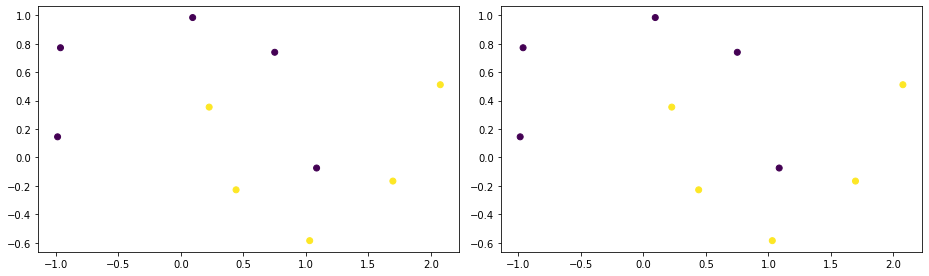

In [23]:
fig, ax = plt.subplots(ncols = 2, figsize = (13, 4))
fig.tight_layout()

# Generate training data and label sets
X,labels = datasets.make_moons(n_samples=N,noise=0.1, random_state = 0)
W = gl.weightmatrix.knn(X,4).toarray()

train_ind = gl.trainsets.generate(labels, rate=5, seed = 0)
train_labels = labels[train_ind]
m = train_ind.size

# Construction of measure mu
# mu[i] = [0, 0] if i is  not in the training dataset
# mu[i] = [1,0] if i is in the training dataset and its label is 1
# mu[i] = [0,1] if i is in the training dataset and its label is 0

a_idx = train_ind[np.argwhere(labels[train_ind] == 1)].flatten()
b_idx = train_ind[np.argwhere(labels[train_ind] == 0)].flatten()
mu = np.zeros((N,k))
mu[a_idx] = [1,0]
mu[b_idx] = [0,1]

ax[0].scatter(X[:,0],X[:,1], c=labels)
ax[1].scatter(X[:,0],X[:,1], c=labels)

In [18]:
u = pd_solver(proxF, proxG)
print(u)

KeyboardInterrupt: ignored

In [25]:
V = np.random.randint(low = -10, high = 10, size = (N,N,k))
V = V - np.transpose(V, [1, 0, 2])
Z = slow_proxF(V)
np.linalg.norm(Z - np.transpose(Z, [1, 0, 2]))

113.61697601026529

In [8]:
proxF(V)
np.linalg.norm(proxF(V) - slow_proxF(V))

164.53155577605506

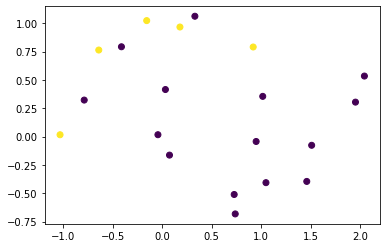

In [9]:
predictions = predict(u)
plt.scatter(X[:,0],X[:,1], c=predictions)

In [22]:
u = pd_solver(slow_proxF, proxG)

KeyboardInterrupt: ignored

In [ ]:
a = np.arange(2 * 2 * 3).reshape((2, 2,3))
b = a % 3
W = np.random.randint(low = 0, high = 3, size = (2,2))
aa = (W[:, :, np.newaxis] + np.zeros((2,2,3))) * a
print(a)
print(b)
print(W)

In [ ]:
def I_F(x_flattened, y_flattened, W, tau):
    n = W.shape[0]
    k = int(x_flattened.size/(n**2))
    x = x_flattened.reshape((n,n,k))
    y = y_flattened.reshape((n,n,k))
    
    return 1/(2*tau) * inner_product(x-y, x-y, W) + 0.5 * (np.apply_along_axis(np.linalg.norm, 2, x) * W).sum()

In [ ]:
y_flattened = np.random.randint(low = 0, high = 20, size = (n*n*k))
res = minimize(I_F, x0 = np.zeros(n * n * k), args = (y_flattened, W, sigma))

In [ ]:
print(res.x)

In [ ]:
np.linalg.norm(proxF(np.zeros((n,n,k)), sigma, W) - res.x.reshape(n,n,k))